# Prioritizing organ/tissue types in cluster-specific caQTLs

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, false_discovery_control, ttest_ind
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.utils import resample

In [ ]:
all_scores_file = Path('caqtl_data/TLand_scores.all.tsv.gz', compress='gzip')
tland_df = pd.read_table(all_scores_file)
tland_df

,chrom,pos,ref,alt,vasculature_TLand_lightest,blood_TLand,placenta_TLand_lightest,lymph node_TLand_lightest,blood vessel_TLand_lightest,ear_TLand_lightest,...,mouth_TLand_lightest,pancreas_TLand_lightest,eye_TLand_lightest,lung_TLand,extraembryonic component_TLand_lightest,intestine_TLand_lightest,small intestine_TLand_lightest,spinal cord_TLand_lightest,epithelium_TLand,thymus_TLand_lightest
0,chr4,149632958,G,A,0.127765,0.130322,0.125189,0.220449,0.126462,0.120590,...,0.191763,0.128447,0.200901,0.126504,0.133358,0.118744,0.225429,0.246604,0.151562,0.274858
1,chr4,149632958,G,C,0.127765,0.128937,0.125189,0.220449,0.126462,0.120590,...,0.191763,0.128447,0.200901,0.125773,0.133358,0.118744,0.225429,0.246604,0.151912,0.274858
2,chr4,149632958,G,T,0.127765,0.128441,0.125189,0.220449,0.126462,0.120590,...,0.191763,0.128447,0.200901,0.125832,0.133358,0.118744,0.225429,0.246604,0.149637,0.274858
3,chr2,63980745,T,C,0.184203,0.126277,0.172515,0.249275,0.182023,0.174354,...,0.251081,0.284982,0.305390,0.124022,0.176995,0.178424,0.157847,0.251138,0.206334,0.189667
4,chr1,233843376,T,G,0.206627,0.157566,0.387243,0.254046,0.306554,0.199551,...,0.249829,0.324658,0.440270,0.133254,0.229021,0.276947,0.179931,0.196597,0.160603,0.185838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1690710,chr17,10453419,C,T,0.113296,0.123984,0.116167,0.113141,0.113296,0.113942,...,0.112654,0.116195,0.112654,0.114553,0.113296,0.116167,0.113900,0.113831,0.115264,0.114609
1690711,chr17,10453964,T,A,0.118227,0.121979,0.123766,0.113475,0.116066,0.121610,...,0.113024,0.124761,0.113023,0.117165,0.116066,0.118467,0.122691,0.115065,0.115425,0.115836
1690712,chr17,10453964,T,G,0.118227,0.121926,0.123766,0.113475,0.116066,0.121610,...,0.113024,0.124761,0.113023,0.117160,0.116066,0.118467,0.122691,0.115065,0.115397,0.115836
1690713,chr9,73225118,G,A,0.129571,0.157058,0.147972,0.137785,0.133365,0.152840,...,0.130592,0.159974,0.130590,0.123196,0.138799,0.141537,0.158309,0.139002,0.123768,0.154314


In [ ]:
vcf_df = pd.read_table('caqtl_data/cluster9.vcf', names=['chrom','pos','rsid','ref','alt'])

In [4]:
tland_df = tland_df.merge(vcf_df, on=['chrom', 'pos', 'ref', 'alt'], how='inner')
tland_df

,chrom,pos,ref,alt,vasculature_TLand_lightest,blood_TLand,placenta_TLand_lightest,lymph node_TLand_lightest,blood vessel_TLand_lightest,ear_TLand_lightest,...,pancreas_TLand_lightest,eye_TLand_lightest,lung_TLand,extraembryonic component_TLand_lightest,intestine_TLand_lightest,small intestine_TLand_lightest,spinal cord_TLand_lightest,epithelium_TLand,thymus_TLand_lightest,rsid
0,chr4,149632958,G,A,0.127765,0.130322,0.125189,0.220449,0.126462,0.120590,...,0.128447,0.200901,0.126504,0.133358,0.118744,0.225429,0.246604,0.151562,0.274858,rs6857256
1,chr4,149632958,G,C,0.127765,0.128937,0.125189,0.220449,0.126462,0.120590,...,0.128447,0.200901,0.125773,0.133358,0.118744,0.225429,0.246604,0.151912,0.274858,rs6857256
2,chr4,149632958,G,T,0.127765,0.128441,0.125189,0.220449,0.126462,0.120590,...,0.128447,0.200901,0.125832,0.133358,0.118744,0.225429,0.246604,0.149637,0.274858,rs6857256
3,chr2,63980745,T,C,0.184203,0.126277,0.172515,0.249275,0.182023,0.174354,...,0.284982,0.305390,0.124022,0.176995,0.178424,0.157847,0.251138,0.206334,0.189667,rs60044466
4,chr1,233843376,T,G,0.206627,0.157566,0.387243,0.254046,0.306554,0.199551,...,0.324658,0.440270,0.133254,0.229021,0.276947,0.179931,0.196597,0.160603,0.185838,rs57449064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1690710,chr17,10453419,C,T,0.113296,0.123984,0.116167,0.113141,0.113296,0.113942,...,0.116195,0.112654,0.114553,0.113296,0.116167,0.113900,0.113831,0.115264,0.114609,rs71360263
1690711,chr17,10453964,T,A,0.118227,0.121979,0.123766,0.113475,0.116066,0.121610,...,0.124761,0.113023,0.117165,0.116066,0.118467,0.122691,0.115065,0.115425,0.115836,rs3826444
1690712,chr17,10453964,T,G,0.118227,0.121926,0.123766,0.113475,0.116066,0.121610,...,0.124761,0.113023,0.117160,0.116066,0.118467,0.122691,0.115065,0.115397,0.115836,rs3826444
1690713,chr9,73225118,G,A,0.129571,0.157058,0.147972,0.137785,0.133365,0.152840,...,0.159974,0.130590,0.123196,0.138799,0.141537,0.158309,0.139002,0.123768,0.154314,rs9657736


In [5]:
tland_rsid_tland_avg = tland_df.groupby('rsid').max().reset_index()
tland_rsid_tland_avg

,rsid,chrom,pos,ref,alt,vasculature_TLand_lightest,blood_TLand,placenta_TLand_lightest,lymph node_TLand_lightest,blood vessel_TLand_lightest,...,mouth_TLand_lightest,pancreas_TLand_lightest,eye_TLand_lightest,lung_TLand,extraembryonic component_TLand_lightest,intestine_TLand_lightest,small intestine_TLand_lightest,spinal cord_TLand_lightest,epithelium_TLand,thymus_TLand_lightest
0,rs10000000,chr4,40087276,A,T,0.129649,0.129578,0.117663,0.142885,0.132288,...,0.130438,0.117575,0.138685,0.117802,0.114766,0.117632,0.128313,0.121661,0.117576,0.136153
1,rs10000014,chr4,177525994,C,T,0.128349,0.133285,0.135663,0.161231,0.128345,...,0.165405,0.151106,0.150003,0.131969,0.127366,0.131524,0.137485,0.140608,0.126688,0.141858
2,rs10000017,chr4,83856972,C,T,0.146273,0.126441,0.126699,0.125740,0.149132,...,0.145103,0.125285,0.169488,0.125768,0.120822,0.127998,0.127339,0.261253,0.126441,0.130387
3,rs1000002,chr3,183917980,C,T,0.510125,0.696816,0.365731,0.361188,0.516650,...,0.528337,0.597009,0.383163,0.131572,0.316474,0.440778,0.365781,0.368298,0.335196,0.323524
4,rs10000030,chr4,102452997,G,A,0.419551,0.721872,0.495341,0.390424,0.385728,...,0.486391,0.454234,0.553060,0.570981,0.405162,0.388749,0.502162,0.398116,0.564413,0.486293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012885,rs9999949,chr4,30971411,A,T,0.314436,0.202622,0.375319,0.689011,0.333250,...,0.731009,0.676927,0.443613,0.174554,0.350738,0.325267,0.403114,0.681012,0.182445,0.474043
1012886,rs9999953,chr4,41780979,G,A,0.116477,0.119110,0.115207,0.120268,0.118927,...,0.116032,0.116286,0.128419,0.116586,0.115787,0.115284,0.120289,0.117784,0.117093,0.115931
1012887,rs9999955,chr4,115865639,T,G,0.146255,0.127196,0.147529,0.168147,0.146819,...,0.255030,0.152432,0.170946,0.123255,0.144712,0.139286,0.163017,0.202354,0.271012,0.147242
1012888,rs9999956,chr4,15723479,G,T,0.622817,0.143776,0.391234,0.482612,0.580422,...,0.637832,0.277659,0.656008,0.746201,0.677397,0.372942,0.472120,0.359454,0.712650,0.470941


In [ ]:
caQTL_cluster9_path = Path('caqtl_data/tensorqtl_cluster9_prinComp87_allChr_10.9.24.cis_qtl.txt.gz')
caQTL_cluster9_df = pd.read_table(caQTL_cluster9_path, compression='gzip')
caQTL_cluster9_df = caQTL_cluster9_df.rename(columns={'variant_id': 'rsid'})
peak_df = pd.read_table('caqtl_data/cpm_peakInfo.txt.gz', header=0, names=['phenotype_id','peak_chr','hg19.peak_start','hg19.peak_end'], compression='gzip')
caQTL_cluster9_df = caQTL_cluster9_df.merge(peak_df, on='phenotype_id', how='left')
caQTL_cluster9_df

,phenotype_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,rsid,start_distance,end_distance,ma_samples,...,pval_nominal,slope,slope_se,pval_perm,pval_beta,qval,pval_nominal_threshold,peak_chr,hg19.peak_start,hg19.peak_end
0,peak_0,13,0.934047,10.36740,74.5384,0.050361,rs201635489,5440,4808,19,...,0.054474,-0.318850,0.163101,0.436563,0.446963,0.818190,0.000029,1,10006,10639
1,peak_1,13,1.029150,11.58830,73.8863,0.009877,rs201535981,1223,1058,35,...,0.010874,-0.431846,0.165168,0.111888,0.100780,0.648489,0.000057,1,16161,16327
2,peak_2,13,0.988963,11.58410,74.9156,0.118118,rs199745162,-456,-626,54,...,0.125570,0.254160,0.163994,0.766234,0.770320,0.869011,0.000042,1,17404,17575
3,peak_4,6,0.973847,4.70647,70.1046,0.464499,rs1342104522,9957,9777,13,...,0.458481,0.131363,0.176242,0.955045,0.949346,0.882893,0.000090,1,29266,29447
4,peak_6,16,0.976524,8.28712,69.5905,0.007437,rs369820305,-1653,-1731,80,...,0.006472,0.307205,0.109535,0.068931,0.064607,0.589288,0.000052,1,135135,135214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1652432,peak_1229396,66,0.961733,16.71830,66.0417,0.078049,rs376409704,7616,7397,91,...,0.065699,0.217192,0.116212,0.758242,0.755954,0.867335,0.000023,9,138207863,138208083
1652433,peak_1229397,52,0.968474,16.72060,66.4088,0.216306,rs78252615,-8960,-9131,59,...,0.197822,0.164461,0.126530,0.986014,0.984099,0.885921,0.000024,9,138209182,138209354
1652434,peak_1229398,48,1.025520,16.13190,63.1476,0.004755,rs10780204,-3784,-4237,93,...,0.002561,0.342477,0.109584,0.063936,0.068583,0.597239,0.000040,9,138211677,138212131
1652435,peak_1229399,47,0.958501,19.19750,68.3101,0.030283,rs201519992,-9762,-9849,74,...,0.026113,-0.271605,0.119576,0.451548,0.466165,0.822338,0.000019,9,138212364,138212452


In [7]:
main_df = tland_rsid_tland_avg.merge(caQTL_cluster9_df, on='rsid', how='left')
main_df['inside_peak'] = (main_df['start_distance'] * main_df['end_distance']) < 0
main_df['peak_length'] = main_df['hg19.peak_end'] - main_df['hg19.peak_start']
main_df['distance_to_peak_midpoint'] = abs((main_df['start_distance'] + main_df['end_distance']) / 2).astype(int)
main_df

,rsid,chrom,pos,ref,alt,vasculature_TLand_lightest,blood_TLand,placenta_TLand_lightest,lymph node_TLand_lightest,blood vessel_TLand_lightest,...,pval_perm,pval_beta,qval,pval_nominal_threshold,peak_chr,hg19.peak_start,hg19.peak_end,inside_peak,peak_length,distance_to_peak_midpoint
0,rs10000000,chr4,40087276,A,T,0.129649,0.129578,0.117663,0.142885,0.132288,...,0.068931,0.075425,0.609633,0.000107,4,40084001,40084073,False,72,3238
1,rs10000000,chr4,40087276,A,T,0.129649,0.129578,0.117663,0.142885,0.132288,...,0.982018,0.980924,0.885548,0.000070,4,40085147,40085789,False,642,1807
2,rs10000014,chr4,177525994,C,T,0.128349,0.133285,0.135663,0.161231,0.128345,...,0.578422,0.575410,0.843162,0.000089,4,177528318,177528950,False,632,2640
3,rs10000017,chr4,83856972,C,T,0.146273,0.126441,0.126699,0.125740,0.149132,...,0.743257,0.753644,0.867125,0.000052,4,83854450,83855903,False,1453,1795
4,rs1000002,chr3,183917980,C,T,0.510125,0.696816,0.365731,0.361188,0.516650,...,0.180819,0.185529,0.722383,0.000088,3,183927567,183927636,False,69,9622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387881,rs9999953,chr4,41780979,G,A,0.116477,0.119110,0.115207,0.120268,0.118927,...,0.304695,0.315075,0.780365,0.000062,4,41777185,41777436,False,251,3668
1387882,rs9999955,chr4,115865639,T,G,0.146255,0.127196,0.147529,0.168147,0.146819,...,0.276723,0.260213,0.759853,0.000103,4,115863340,115863497,False,157,2220
1387883,rs9999956,chr4,15723479,G,T,0.622817,0.143776,0.391234,0.482612,0.580422,...,0.203796,0.188724,0.724250,0.000047,4,15721906,15722230,False,324,1410
1387884,rs9999956,chr4,15723479,G,T,0.622817,0.143776,0.391234,0.482612,0.580422,...,0.678322,0.680450,0.858557,0.000053,4,15724773,15726283,False,1510,2049


In [8]:
peak_snps_100bp_from_midpoint = main_df[(main_df['distance_to_peak_midpoint'] <= 100) & (main_df['inside_peak'] == True)].copy()
peak_snps_100bp_from_midpoint['caQTL'] = peak_snps_100bp_from_midpoint['qval'] < 0.05

Description of final processed dataset for running Welch's t-test:

- SNPs within peak AND within 100bp of peak midpoint.
- Positive caQTLs defined as SNPs with qval<0.05, rest are negative.

### Testing and plotting

In [11]:
# Run Welch's t-test
score_pval_dict = {}
score_cols = [col for col in main_df.columns if 'TLand' in col]
for score in score_cols:
    _, pval = ttest_ind(peak_snps_100bp_from_midpoint[peak_snps_100bp_from_midpoint['caQTL']][score], 
                        peak_snps_100bp_from_midpoint[~peak_snps_100bp_from_midpoint['caQTL']][score], 
                        equal_var=False, alternative='greater')
    score_pval_dict[score] = pval

In [12]:
score_pval_df = pd.DataFrame.from_dict(score_pval_dict, orient='index', columns=['pval'])
score_pval_df['qval'] = false_discovery_control(score_pval_df['pval'], method='by')
score_pval_df

,pval,qval
vasculature_TLand_lightest,4.228864e-59,6.497212e-58
blood_TLand,6.402195e-138,1.475446e-135
placenta_TLand_lightest,5.759362e-52,5.530414e-51
lymph node_TLand_lightest,3.336377e-79,1.098428e-77
blood vessel_TLand_lightest,8.613714e-58,1.167713e-56
ear_TLand_lightest,1.730135e-60,2.848042e-59
arterial blood vessel_TLand_lightest,2.547316e-30,1.544877e-29
penis_TLand_lightest,3.316730e-54,3.639866e-53
heart_TLand_lightest,1.821359e-70,4.197494e-69
stomach_TLand_lightest,2.630343e-72,6.735417e-71


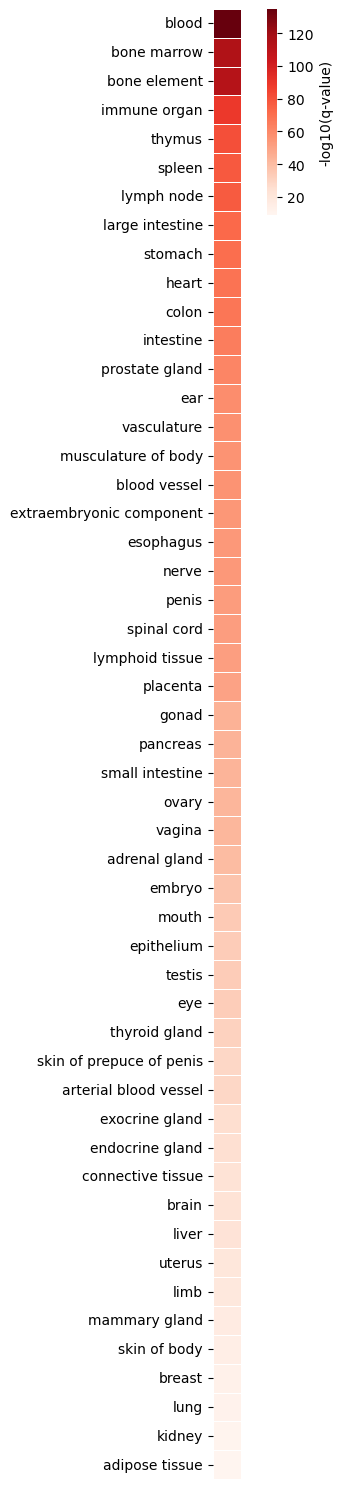

In [ ]:
plt.figure(figsize=(6, 15))
sorted_df = score_pval_df.copy()
sorted_df['-log10_qval'] = -np.log10(sorted_df['qval'])
sorted_df = sorted_df.sort_values('-log10_qval', ascending=False)
sns.heatmap(
    sorted_df['-log10_qval'].values.reshape(-1, 1),
    annot=False,
    cmap='Reds',
    cbar=True,
    cbar_kws={'location': 'right', 'anchor': (0,1), 'label': '-log10(q-value)', 'fraction': 0.02},
    yticklabels=sorted_df.index.str.split('_').str[0],
    xticklabels=[''],
    linewidths=0.5,
    linecolor='white',
    square=True
)
plt.tick_params(bottom=False)
plt.tight_layout()
plt.show()

Figure 3e

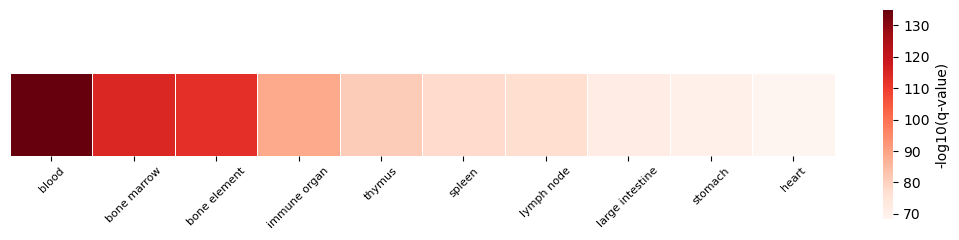

In [ ]:
plt.figure(figsize=(10, 2.5))
sorted_df = score_pval_df.copy()
sorted_df['-log10_qval'] = -np.log10(sorted_df['qval'])
sorted_df = sorted_df.sort_values('-log10_qval', ascending=False)
top10 = sorted_df.head(10)
sns.heatmap(
    top10['-log10_qval'].values.reshape(1, -1),
    annot=False,
    cmap='Reds',
    cbar=True,
    cbar_kws={'label': '-log10(q-value)', 'fraction': 0.1},
    yticklabels=[''],
    xticklabels=top10.index.str.split('_').str[0],
    linewidths=0.5,
    linecolor='white',
    square=True
)
plt.tick_params(left=False)
plt.xticks(rotation=45, ha='center', fontsize=8)
plt.tight_layout()
plt.show()